In [1]:
import sys
sys.path.append('utils/')
from extract_classifiers import *
from config import *
from eval.captioner import *
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

coco_template = 'images/ipython_images/coco/COCO_val2014_%012d.jpg' 

In [2]:
#build feature extractor

#These lexical features are trained with MSCOCO images.  For images which include a held out class (e.g., "zebra") 
#only the held-out class is used as the label.  All other class labels are given a label of "-1" (or ignore label.)
#For images which do not include a held out class, multiple labels
#are mined from visual descriptions (e.g., "A young girl with a blue sweater" --> labels: "young", "girl", "blue",
#"sweater") 
coco_model = 'prototxts/train_classifiers_deploy.prototxt'
coco_model_weights = 'snapshots/attributes_JJ100_NN300_VB100_coco_471_eightCluster_0223_iter_80000.caffemodel'

#These lexical features are trained with MSCOCO images and > 600 ImageNet classes specifically chosen such that they do
#not overlap with categories seen in MSCOCO.  For all MSCOCO images, labels are mined from visual descriptions.  For 
#ImageNet images, categories mined from MSCOCO descriptions are given a "-1" (ignore label).  This is done because
#in many ImageNet images classes like "grass" or "yellow" are present

imagenet_model = 'prototxts/train_classifiers_deploy.prototxt'
imagenet_model_weights = 'snapshots/attributes_JJ100_NN300_VB100_coco_471_eightCluster_0223_iter_80000.caffemodel'

coco_extractor = VisualFeatureExtractor(coco_model, coco_model_weights, device=0, feature_extract='probs')
coco_extractor.build_image_processor()

imagenet_model = 'prototxts/train_classifiers_deploy.imagenet.prototxt'
imagenet_model_weights = 'snapshots/vgg_multilabel_FT_iter_100000.caffemodel'

imagenet_extractor = VisualFeatureExtractor(imagenet_model, imagenet_model_weights, device=0, feature_extract='probs')
imagenet_extractor.build_image_processor()

In [3]:
#Extract features for coco and Imagenet images.

def make_feature_dict(features, ims):
    feature_dict = {}
    for i, im in enumerate(ims):
        feature_dict[im] = features[i,:]
    return feature_dict
        
coco_images = [coco_template %im_id for im_id in [380868, 356368, 279846, 531563]]
feature_dict_coco = make_feature_dict(coco_extractor.extract_batch_features(coco_images), coco_images)

imagenet_images = ['images/ipython_images/' + im_id for im_id in ['otter/n02444819_13167.JPEG', 
                                                              'otter/n02444819_10502.JPEG',
                                                              'alpaca/n02698473_518.JPEG',
                                                              'candelabra/n02947818_15145.JPEG',
                                                              'baobab/n12189987_4309.JPEG']]
feature_dict_imagenet = make_feature_dict(imagenet_extractor.extract_batch_features(imagenet_images), imagenet_images)

In [4]:
#Build dcc captioner for coco and Imagenet
def build_captioner(proto, weights, vocab):
    language_model = models_folder + proto
    model_weights = weights_folder + weights
    vocab = vocab_root + vocab


    captioner = Captioner(language_model, model_weights,
                            sentence_generation_cont_in='cont_sentence',
                            sentence_generation_sent_in='input_sentence',
                            sentence_generation_feature_in=['image_features'],
                            sentence_generation_out='predict',
                            vocab_file=vocab,
                            prev_word_restriction=True)
    return captioner

#coco models

language_prototxt = 'dcc_vgg.wtd.prototxt'
vocab = 'vocabulary.txt'
coco_no_transfer_weights = 'dcc_coco_rm1_vgg.471.solver.prototxt_iter_110000.caffemodel'
coco_transfer_weights = 'dcc_coco_rm1_vgg.471.solver.prototxt_iter_110000.transfer_words_coco1.txt_closeness_embedding.caffemodel'

coco_no_transfer_captioner = build_captioner(language_prototxt, coco_no_transfer_weights, vocab)
gen_captions_no_transfer = coco_no_transfer_captioner.caption_images(feature_dict_coco, 
                                                                     feature_dict_coco.keys(), batch_size=1000)

coco_transfer_captioner = build_captioner(language_prototxt, coco_transfer_weights, vocab)
gen_captions_transfer = coco_transfer_captioner.caption_images(feature_dict_coco, 
                                                      feature_dict_coco.keys(), batch_size=1000)

#ImageNet models

language_prototxt = 'dcc_vgg.80k.wtd.imagenet.prototxt'
vocab = 'yt_coco_surface_80k_vocab.txt'
imagenet_no_transfer_weights = 'vgg_feats.vgg_multilabel_FT_iter_100000_imagenetSentences_iter_110000.caffemodel'
imagenet_transfer_weights = 'vgg_feats.vgg_multilabel_FT_iter_100000_imagenetSentences_iter_110000.transfer_words_imagenet.txt_closeness_embedding.caffemodel'

imagenet_no_transfer_captioner = build_captioner(language_prototxt, imagenet_no_transfer_weights, vocab)
gen_captions_no_transfer_imagenet = imagenet_no_transfer_captioner.caption_images(feature_dict_imagenet, 
                                                                     feature_dict_imagenet.keys(), batch_size=1000)
imagenet_transfer_captioner = build_captioner(language_prototxt, imagenet_transfer_weights, vocab)
gen_captions_transfer_imagenet = imagenet_transfer_captioner.caption_images(feature_dict_imagenet, 
                                                      feature_dict_imagenet.keys(), batch_size=1000)

Captioning image: 0/4
4/4 done after word 12
Captioning image: 0/4
4/4 done after word 12
Captioning image: 0/5
5/5 done after word 11
Captioning image: 0/5
5/5 done after word 11


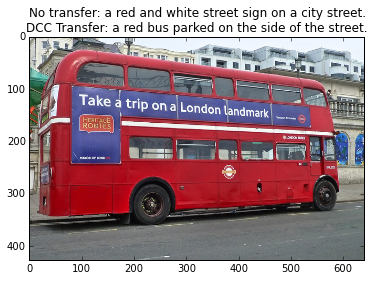

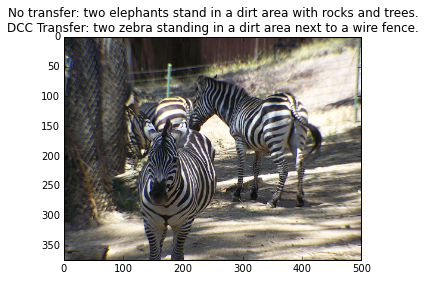

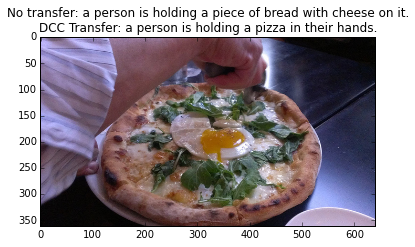

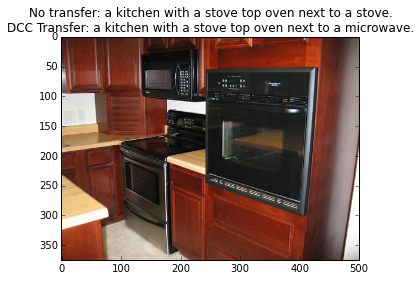

In [5]:
for i, img in enumerate(coco_images):
    img_read=mpimg.imread(img)
    plt.figure()
    plt.imshow(img_read)
    plt.title("No transfer: %s\nDCC Transfer: %s" %(gen_captions_no_transfer[img], gen_captions_transfer[img]))

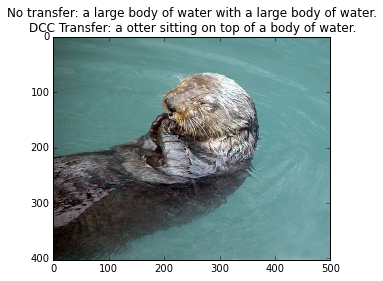

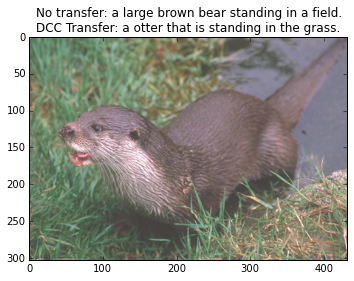

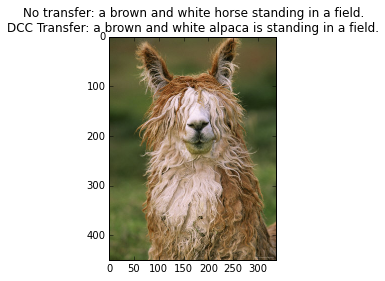

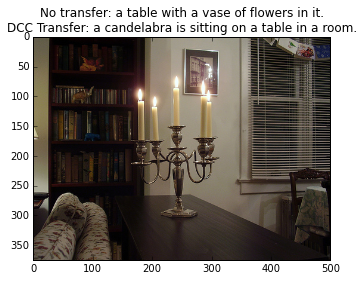

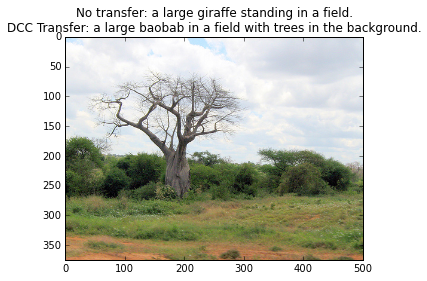

In [6]:
for i, img in enumerate(imagenet_images):
    img_read=mpimg.imread(img)
    plt.figure()
    plt.imshow(img_read)
    plt.title("No transfer: %s\nDCC Transfer: %s" %(gen_captions_no_transfer_imagenet[img], 
                                                gen_captions_transfer_imagenet[img]))